In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# cat dog 이미지 분류 --> 파일 압축을 풀고 진행
# --> linux 명령어 사용

In [ ]:
!unzip -q -o /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
!unzip -q -o /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip
# -q : 압축파일(25000개) 하나하나 풀때마다 라인표시하지 않겠다!
# -o : 나중에 여러번 실행해도 오류나지 않게하겠다!

In [ ]:
import glob
glob.glob('/kaggle/working/train/*')[:5]
# glob.glob() : 저장된 압축파일 로드
# 너무 많으므로 5개만 표시되게함!

In [ ]:
from PIL import Image
Image.open('/kaggle/working/train/dog.6603.jpg')
# Image : 이미지 파일 확인하는 모듈

In [ ]:
Image.open('/kaggle/working/train/cat.1757.jpg')

In [ ]:
# 데이터 전처리 및 모델링
# 1) 데이터 프레임화를 시킨후 컬럼(경로,이미지에대한 정답값)까지 생성
# 2) 이미지 전처리 --> 에 필요한 라이브러리 활용

In [ ]:
# 데이터 전처리 & 모델링
# 1) 데이터프레임화 시킨후 컬럼(경로,이미지에대한 정답값)까지 생성
# 2) 이미지 전처리에 필요한 라이브러리 활용

In [ ]:
train = pd.DataFrame({'path' : glob.glob('/kaggle/working/train/*')})
train

In [ ]:
# 정답컬럼 만들기
# train 데이터셋의 dog/cat으로 구분 ㄱㄱ
train['label'] = train['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
train

In [ ]:
# 딥러닝 모듈로 이미지데이터 전처리(ImageDataGenerator)
# 이미지 크기, 화질, ... 등을 동일하게 맞추기 위함
# + RAM 소모량을 줄이기 위함(batch_size를 맞춰줌으로써)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator()
train_generator = idg.flow_from_dataframe(train,x_col='path',y_col='label',
                                         target_size=(100,100),batch_size=100)
# idg.flow_from_dataframe(데이터셋 이름, 이미지주소컬럼('컬럼이름'만쓰기!), 정답컬럼('컬럼이름'만!),
#                          이미지 사이즈=(가로,세로), 몇개씩 데이터를 처리할 것인가?)
train_generator
# 25000개의 이미지를 2classes --> 이진분류

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 모델링 1
from tensorflow.keras import *
from tensorflow.keras.layers import *
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3))) # 입력층
# Conv2D : CNN 이미지 처리 --> 3차원
# 첫번째 옵션(32) : 정답클래스(강/고) 구분가능한 특성을 32개 추출(one-hot encoding 컬럼을 32개 생성하는것!)
# --> 숫자는 변경 가능(보통 32,64, 128....)
# 두번째 옵션(3,3) : 커널(필터)의 크기
# 세번째 옵션 --> 활성화함수(relu)
# 네번째 옵션(input_shape=())  : 가로 100 세로 100 3차원의 데이터 형식으로!
model.add(Flatten())
# Flatten() : 입력층 Conv2D와 Dense의 차원을 연결하기 위해 3차원 --> 1차원
model.add(Dense(2,activation='softmax'))  # 출력층
# Dense(정답 클래스 개수, 활성화함수) --> 1차원
# softmax함수 : 어떤 값이 들어와도 출력값이 0~1사이의 확률로 출력 + 모든 클래스 확률합은 1이 됨
model.compile(metrics=['acc'],loss='categorical_crossentropy',optimizer='adam')
# metrics : 모델 정확도 측정하는 옵션
# loss : 손실함수 --> categorical_crossentropy(분류) => batch_size=100으로 한번에 100개씩 들어오는 데이터가
# 좋은데이터인지 아닌지를 loss값으로 판단(낮을수록 좋음) --> 데이터가 좋다면 데이터에서 쓰인 가중치를 저장/나쁘다면 가중치를 버림
# --> 올바른 방향으로 학습하기 위함
# 회귀 손실함수 --> mean squared error
# optimizer : 최적화함수(모델의 성격 및 복합도 지정)
# --> adam : 대부분 adam옵티마이저를 사용 
model.fit(train_generator)

In [ ]:
# 모델링 2
# MaxPool2D를 사용
from tensorflow.keras import *
from tensorflow.keras.layers import *
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3))) # 입력층
model.add(MaxPool2D())
# MaxPool2D() : 각 이미지 픽셀의 특징적인 값만 가져오겠다(너무 일일이 다 공부하는 과대적합방지)
#               보통 2*2 Pool 사이즈로 가져온다
model.add(Conv2D(64,(3,3),activation='relu'))  # MaxPool2D 한번 더 실행하는 층 추가
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.compile(metrics=['acc'],optimizer='adam',loss='categorical_crossentropy')
model.fit(train_generator)

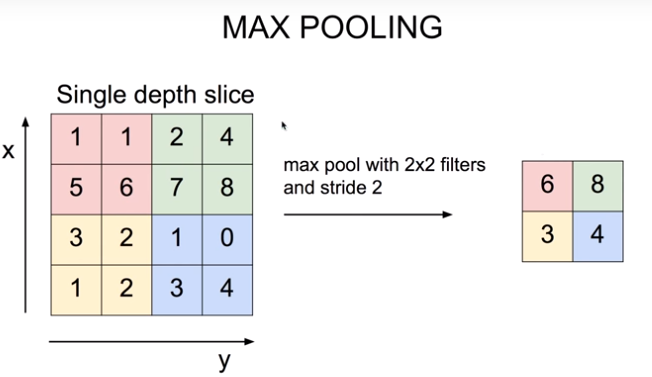

In [ ]:
# 테스트 df만들기
# 경로(path) 컬럼만 만들기
test = pd.DataFrame({'path' : glob.glob('test/*')})
test

In [ ]:
# test_generator
test_generator = idg.flow_from_dataframe(test,x_col='path',y_col=None,target_size=(100,100),
                                        batch_size=100,class_mode=None,shuffle=False)
# class_mode=None : 디폴트값 categorical --> 정답컬럼이 test데이터셋엔 없으므로 없다고 지정!
# shuffle = False : 디폴트값 True --> 원래는 더좋은 가중치를 찾기위해 True로 해주는게 좋지만
#                                 test데이터셋 예측시 순서가 달라져버리면 인덱스가 안맞는 경우가 있음

In [ ]:
result = model.predict(test_generator,verbose=1,workers=3) # verbose=1 : 딥러닝 시간 확인용
# workers --> 예측에 쓸 CPU개수 (많다고 좋은게 아님)
result
# predict_proba가 아닌데도 왜 확률값으로 나오는지?
# --> softmax함수를 출력층에 적었으므로!(0~1사이!)

In [ ]:
sub = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
sub['label'] = result[:,1]
sub

In [ ]:
# 예측때 test데이터셋은 랜덤하게 섞여있었음 --> submission과 순서를 맞춰줘야함!
sub['id'] = test['path'].apply(lambda x: x.split('/')[1].split('.')[0])
sub

In [ ]:
sub.to_csv('result.csv',index=False)